In [ ]:
import os
from google.colab import userdata

In [ ]:
!pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 23.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from rfdetr import RFDETRNano

In [ ]:
from PIL import Image
import supervision as sv

Image

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 1 classes
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Raw detections count: 2
RAW DETECTIONS SAMPLE:
[0] type=<class 'tuple'> repr=(array([1025.5071 ,  388.20602, 1101.5536 ,  554.8593 ], dtype=float32), None, np.float32(0.6598684), np.int64(0), None, {})
[1] type=<class 'tuple'> repr=(array([1336.6301 ,  488.67892, 1440.6403 ,  595.5233 ], dtype=float32), None, np.float32(0.598478), np.int64(0), None, {})


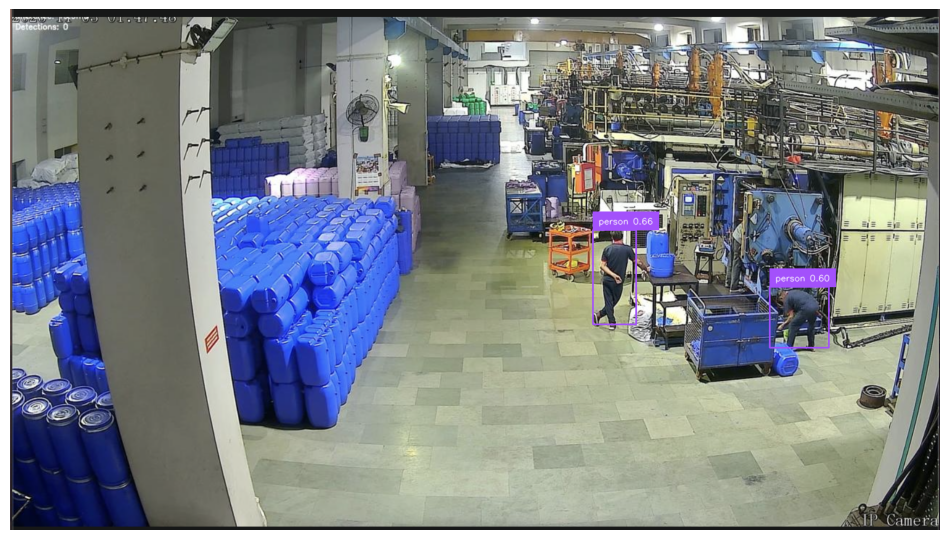

In [ ]:
# Colab cell — paste & run
import os
# Install once in Colab (uncomment if running fresh)
# !pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

import torch
import numpy as np
from PIL import Image
import supervision as sv

from rfdetr import RFDETRNano

# ---------------------------
# LOAD MODEL
# ---------------------------
checkpoint_path = "/content/drive/MyDrive/Guardex_Harshvardhan/RFDETR-DATA+TRAINING+INFERENCE/RFDETR-Finetuned-1280x720/checkpoint_best_ema.pth"
model = RFDETRNano(pretrain_weights=checkpoint_path)
try:
    model.optimize_for_inference()
except Exception:
    # not fatal if unavailable
    pass

# ---------------------------
# CONFIG
# ---------------------------
class_names = ["person"]   # <-- replace/add if your model has more classes
IMAGE_PATH = "/content/Screenshot 2025-11-04 at 3.48.59 PM.png"
THRESHOLD = 0.2

# ---------------------------
# HELPERS: robust parsing of a single detection entry
# ---------------------------
def _to_float_if_scalar(x):
    """Return python float if x is a scalar-like value (torch tensor 0-dim, numpy scalar/array size 1, python number), else None."""
    if x is None:
        return None
    if isinstance(x, torch.Tensor):
        try:
            return float(x.detach().cpu().item())
        except Exception:
            return None
    if isinstance(x, (np.generic, np.ndarray)):
        try:
            arr = np.array(x)
            if arr.size == 1:
                return float(arr.reshape(-1)[0])
            return None
        except Exception:
            return None
    if isinstance(x, (float, int)):
        return float(x)
    try:
        return float(x)
    except Exception:
        return None

def _is_bbox_like(x):
    """Return True if x looks like a bbox (array-like with >=4 numeric elements)."""
    if x is None:
        return False
    if isinstance(x, torch.Tensor):
        try:
            arr = x.detach().cpu().numpy()
            return arr.size >= 4
        except Exception:
            return False
    try:
        arr = np.array(x, dtype=np.float32)
        return arr.size >= 4
    except Exception:
        return False

def _parse_detection(det):
    """
    Parse a single detection item into (bbox, confidence, class_id).
    Returns (bbox_list_of_4_floats, confidence_float_or_0.0, class_id_int_or_0)
    If a bbox can't be found returns (None, None, None).
    This handles tuple/list, dict, or object-like formats.
    """
    bbox = None
    conf = None
    cls = None

    # tuple/list: scan elements
    if isinstance(det, (list, tuple)):
        for elem in det:
            # bbox candidate
            if bbox is None and _is_bbox_like(elem):
                try:
                    if isinstance(elem, torch.Tensor):
                        arr = elem.detach().cpu().numpy().astype(np.float32).reshape(-1)
                    else:
                        arr = np.array(elem, dtype=np.float32).reshape(-1)
                    bbox = arr[:4].tolist()
                    continue
                except Exception:
                    pass
            # confidence candidate: prefer numeric in [0,1]
            if conf is None:
                val = _to_float_if_scalar(elem)
                if val is not None and 0.0 <= val <= 1.0:
                    conf = float(val)
                    continue
            # class id candidate: integer-like
            if cls is None:
                val = _to_float_if_scalar(elem)
                if val is not None and abs(val - round(val)) < 1e-6:
                    cls = int(round(val))
                    continue
        # fallback: if conf still None, pick first scalar numeric
        if conf is None:
            for elem in det:
                val = _to_float_if_scalar(elem)
                if val is not None:
                    conf = float(val)
                    break

    # dict-like
    elif isinstance(det, dict):
        bbox_candidate = det.get('bbox') or det.get('box') or det.get('xyxy') or det.get('boxes') or det.get('bboxes')
        if _is_bbox_like(bbox_candidate):
            arr = np.array(bbox_candidate, dtype=np.float32).reshape(-1)[:4]
            bbox = arr.tolist()
        conf_candidate = det.get('score') or det.get('confidence') or det.get('scores')
        cval = _to_float_if_scalar(conf_candidate)
        if cval is not None:
            conf = float(cval)
        cls_candidate = det.get('class') or det.get('label') or det.get('class_id') or det.get('class_ids')
        kval = _to_float_if_scalar(cls_candidate)
        if kval is not None:
            cls = int(round(kval))

    # object-like with attributes
    else:
        for attr in ('bbox','xyxy','box','boxes','bboxes'):
            if hasattr(det, attr):
                val = getattr(det, attr)
                if _is_bbox_like(val):
                    arr = np.array(val, dtype=np.float32).reshape(-1)[:4]
                    bbox = arr.tolist()
                    break
        for attr in ('score','scores','confidence','conf'):
            if conf is None and hasattr(det, attr):
                val = _to_float_if_scalar(getattr(det, attr))
                if val is not None:
                    conf = float(val)
        for attr in ('label','class_id','class','class_ids'):
            if cls is None and hasattr(det, attr):
                val = _to_float_if_scalar(getattr(det, attr))
                if val is not None:
                    cls = int(round(val))

    # Final fallbacks
    if bbox is None:
        return None, None, None
    if conf is None:
        # keep fallback but log (we use 0.0 to avoid dtype errors)
        # (If you prefer to skip such detections, return None earlier)
        conf = 0.0
    if cls is None:
        cls = 0

    return bbox, float(conf), int(cls)

# ---------------------------
# Load & Prepare Image
# ---------------------------
def load_and_prepare(path):
    img = Image.open(path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

image = load_and_prepare(IMAGE_PATH)

# ---------------------------
# Run Inference, convert & annotate
# ---------------------------
detections = model.predict(image, threshold=THRESHOLD)
print("Raw detections count:", len(detections))

if len(detections) == 0:
    print("⚠️ No detections found.")
    annotated = image.copy()
else:
    # Debug print 1st few raw detections so you see format
    print("RAW DETECTIONS SAMPLE:")
    for i, d in enumerate(detections[:4]):
        print(f"[{i}] type={type(d)} repr={repr(d)[:300]}")

    xyxy_list = []
    conf_list = []
    cid_list = []

    for det in detections:
        bbox, conf, cid = _parse_detection(det)
        if bbox is None:
            # skip malformed detection
            continue
        xyxy_list.append(bbox)
        conf_list.append(conf)
        cid_list.append(cid)

    if len(xyxy_list) == 0:
        print("⚠️ After parsing, no valid detections remained.")
        annotated = image.copy()
    else:
        xyxy = np.array(xyxy_list, dtype=np.float32)
        confidences = np.array(conf_list, dtype=np.float32)
        class_ids = np.array(cid_list, dtype=np.int32)

        detections_sv = sv.Detections(
            xyxy=xyxy,
            confidence=confidences,
            class_id=class_ids
        )

        labels = [f"{class_names[int(c)]} {conf:.2f}" for c, conf in zip(class_ids, confidences)]

        box_annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()

        annotated = box_annotator.annotate(image.copy(), detections_sv)
        annotated = label_annotator.annotate(annotated, detections_sv, labels=labels)

# ---------------------------
# Show result
# ---------------------------
sv.plot_image(annotated)

Video

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# checkpoint_path = "/content/drive/MyDrive/Guardex_Harshvardhan/RFDETR_finetuned_model_v1.0/checkpoint_best_ema.pth"
checkpoint_path = "/content/drive/MyDrive/Guardex_Harshvardhan/RFDETR-DATA+TRAINING+INFERENCE/RFDETR-Finetuned-29thOct2025/checkpoint_best_ema.pth"

In [ ]:
model = RFDETRNano(pretrain_weights=checkpoint_path)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 1 classes


In [ ]:
model.optimize_for_inference()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [ ]:
#!/usr/bin/env python3
"""
Batch Video Annotation Script (updated)

This script:
- Takes an input folder containing multiple videos
- Runs your detection model on each video frame-by-frame
- Saves annotated videos to your specified output folder
- Writes confidence score for each detected person on the bbox

Make sure you have:
    - cv2
    - supervision
    - PIL
    - numpy
installed and that `model` (your loaded RF-DETR model) is available in the scope.
"""

import cv2
from PIL import Image
import supervision as sv
import numpy as np
from pathlib import Path
import torch

# -------------------
# CONFIG
# -------------------
VIDEO_INPUT_DIR = Path("/content/drive/MyDrive/sharda_recs")     # Folder containing videos
VIDEO_OUTPUT_DIR = Path("/content/drive/MyDrive/Guardex_Harshvardhan/RFDETR-DATA+TRAINING+INFERENCE/RFDETR-Finetuned-19thOct2025/Test-Output")   # Folder to save annotated videos
THRESHOLD = 0.4

# Your class list (same order as training)
class_names = ["person"]  # <-- replace with your actual class names if different

# -------------------
# HELPERS
# -------------------
def _to_float_if_scalar(x):
    """Return python float if x is a scalar-like value (torch tensor 0-dim, numpy scalar), else None."""
    if x is None:
        return None
    if isinstance(x, torch.Tensor):
        try:
            return float(x.detach().cpu().item())
        except Exception:
            return None
    if isinstance(x, (np.generic, np.ndarray)):
        try:
            arr = np.array(x)
            if arr.size == 1:
                return float(arr.reshape(-1)[0])
            return None
        except Exception:
            return None
    if isinstance(x, (float, int)):
        return float(x)
    try:
        return float(x)
    except Exception:
        return None

def _is_bbox_like(x):
    """Return True if x looks like a bbox (array-like with >=4 numeric elements)."""
    if x is None:
        return False
    if isinstance(x, torch.Tensor):
        try:
            arr = x.detach().cpu().numpy()
            return arr.size >= 4
        except Exception:
            return False
    try:
        arr = np.array(x, dtype=np.float32)
        return arr.size >= 4
    except Exception:
        return False

def _parse_detection(det):
    """
    Parse a single detection item into (bbox, confidence, class_id).
    - bbox -> list of 4 floats [x1, y1, x2, y2]
    - confidence -> float in [0,1] (or fallback 0.0)
    - class_id -> int (or fallback 0)
    This function is defensive and handles tuple/list, dict, and object-like detections.
    """
    bbox = None
    conf = None
    cls = None

    # If tuple/list -> scan elements
    if isinstance(det, (list, tuple)):
        for elem in det:
            # detect bbox-like element first
            if bbox is None and _is_bbox_like(elem):
                try:
                    if isinstance(elem, torch.Tensor):
                        arr = elem.detach().cpu().numpy().astype(np.float32).reshape(-1)
                    else:
                        arr = np.array(elem, dtype=np.float32).reshape(-1)
                    bbox = arr[:4].tolist()
                    continue
                except Exception:
                    pass
            # detect scalar as confidence candidate (prefer values in [0,1])
            if conf is None:
                val = _to_float_if_scalar(elem)
                if val is not None and 0.0 <= val <= 1.0:
                    conf = float(val)
                    continue
            # detect integer-like class id
            if cls is None:
                val = _to_float_if_scalar(elem)
                if val is not None and abs(val - round(val)) < 1e-6:
                    cls = int(round(val))
                    continue
        # if conf still None, pick first scalar numeric as fallback
        if conf is None:
            for elem in det:
                val = _to_float_if_scalar(elem)
                if val is not None:
                    conf = float(val)
                    break

    # If dict-like
    elif isinstance(det, dict):
        # bbox candidates
        bbox_candidate = det.get('bbox') or det.get('box') or det.get('xyxy') or det.get('boxes') or det.get('bboxes')
        if _is_bbox_like(bbox_candidate):
            arr = np.array(bbox_candidate, dtype=np.float32).reshape(-1)[:4]
            bbox = arr.tolist()
        conf_candidate = det.get('score') or det.get('confidence') or det.get('scores')
        conf_val = _to_float_if_scalar(conf_candidate)
        if conf_val is not None:
            conf = conf_val
        cls_candidate = det.get('class') or det.get('label') or det.get('class_id') or det.get('class_ids')
        cls_val = _to_float_if_scalar(cls_candidate)
        if cls_val is not None:
            cls = int(round(cls_val))

    # object-like (attributes)
    else:
        for attr in ('bbox','xyxy','box','boxes','bboxes'):
            if hasattr(det, attr):
                val = getattr(det, attr)
                if _is_bbox_like(val):
                    arr = np.array(val, dtype=np.float32).reshape(-1)[:4]
                    bbox = arr.tolist()
                    break
        for attr in ('score','scores','confidence','conf'):
            if conf is None and hasattr(det, attr):
                val = _to_float_if_scalar(getattr(det, attr))
                if val is not None:
                    conf = float(val)
        for attr in ('label','class_id','class','class_ids'):
            if cls is None and hasattr(det, attr):
                val = _to_float_if_scalar(getattr(det, attr))
                if val is not None:
                    cls = int(round(val))

    # Final fallbacks
    if bbox is None:
        return None, None, None  # can't use this detection

    if conf is None:
        conf = 0.0  # fallback so array creation won't crash

    if cls is None:
        cls = 0

    return bbox, float(conf), int(cls)


# -------------------
# Frame inference
# -------------------
def run_inference_on_frame(frame_bgr):
    """
    Runs your trained model on a single BGR frame.
    Returns (xyxy, confidences, class_ids) as numpy arrays.
    """
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)

    # Run prediction using your existing model
    detections = model.predict(pil_img, threshold=THRESHOLD)

    if len(detections) == 0:
        return (
            np.empty((0, 4), dtype=np.float32),
            np.empty((0,), dtype=np.float32),
            np.empty((0,), dtype=np.int32)
        )

    xyxy_list = []
    confs_list = []
    class_ids_list = []

    for det in detections:
        bbox, conf, cls = _parse_detection(det)
        if bbox is None:
            # skip malformed detection
            continue
        xyxy_list.append(bbox)
        confs_list.append(conf)
        class_ids_list.append(cls)

    if len(xyxy_list) == 0:
        return (
            np.empty((0, 4), dtype=np.float32),
            np.empty((0,), dtype=np.float32),
            np.empty((0,), dtype=np.int32)
        )

    xyxy = np.array(xyxy_list, dtype=np.float32)
    confidences = np.array(confs_list, dtype=np.float32)
    class_ids = np.array(class_ids_list, dtype=np.int32)
    return xyxy, confidences, class_ids


def make_labels(class_ids, confidences):
    """Generate human-readable labels for each detection."""
    labels = []
    for c, conf in zip(class_ids, confidences):
        class_name = class_names[int(c)] if int(c) < len(class_names) else "unknown"
        labels.append(f"{class_name} {float(conf):.2f}")
    return labels


def process_video(video_path: Path, output_path: Path):
    """Process a single video, frame-by-frame."""
    print(f"🎥 Processing: {video_path.name}")

    try:
        video_info = sv.VideoInfo.from_video_path(video_path)
        frame_generator = sv.get_video_frames_generator(video_path)

        # Prepare output path
        output_path.parent.mkdir(parents=True, exist_ok=True)

        # Initialize annotators
        box_annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()

        with sv.VideoSink(str(output_path), video_info) as sink:
            for frame in frame_generator:
                xyxy, confidences, class_ids = run_inference_on_frame(frame)

                detections_sv = sv.Detections(
                    xyxy=xyxy,
                    confidence=confidences,
                    class_id=class_ids
                )

                labels = make_labels(class_ids, confidences)
                annotated = box_annotator.annotate(frame.copy(), detections_sv)
                annotated = label_annotator.annotate(annotated, detections_sv, labels=labels)
                sink.write_frame(annotated)

        print(f"✅ Saved annotated video: {output_path}")

    except Exception as e:
        print(f"❌ Error processing {video_path.name}: {e}")


# -------------------
# MAIN LOOP
# -------------------
def main():
    VIDEO_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    video_files = [p for p in VIDEO_INPUT_DIR.glob("*") if p.suffix.lower() in [".mp4", ".avi", ".mov", ".mkv"]]
    if not video_files:
        print(f"⚠️ No videos found in {VIDEO_INPUT_DIR}")
        return

    print(f"Found {len(video_files)} videos to process.\n")

    for video_path in video_files:
        output_path = VIDEO_OUTPUT_DIR / f"{video_path.stem}_annotated{video_path.suffix}"
        process_video(video_path, output_path)

    print("\n🎉 All videos processed!")


if __name__ == "__main__":
    main()

Found 20 videos to process.

🎥 Processing: sharda_101_20251017_001010.mp4
✅ Saved annotated video: /content/drive/MyDrive/Guardex_Harshvardhan/RFDETR-DATA+TRAINING+INFERENCE/RFDETR-Finetuned-19thOct2025/Test-Output/sharda_101_20251017_001010_annotated.mp4
🎥 Processing: sharda_201_20251017_001113.mp4
✅ Saved annotated video: /content/drive/MyDrive/Guardex_Harshvardhan/RFDETR-DATA+TRAINING+INFERENCE/RFDETR-Finetuned-19thOct2025/Test-Output/sharda_201_20251017_001113_annotated.mp4
🎥 Processing: sharda_301_20251017_001215.mp4
✅ Saved annotated video: /content/drive/MyDrive/Guardex_Harshvardhan/RFDETR-DATA+TRAINING+INFERENCE/RFDETR-Finetuned-19thOct2025/Test-Output/sharda_301_20251017_001215_annotated.mp4
🎥 Processing: sharda_401_20251017_001318.mp4
✅ Saved annotated video: /content/drive/MyDrive/Guardex_Harshvardhan/RFDETR-DATA+TRAINING+INFERENCE/RFDETR-Finetuned-19thOct2025/Test-Output/sharda_401_20251017_001318_annotated.mp4
🎥 Processing: sharda_501_20251017_001420.mp4
✅ Saved annotated 

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 1 classes


Raw detections count: 0
⚠️ No detections found.


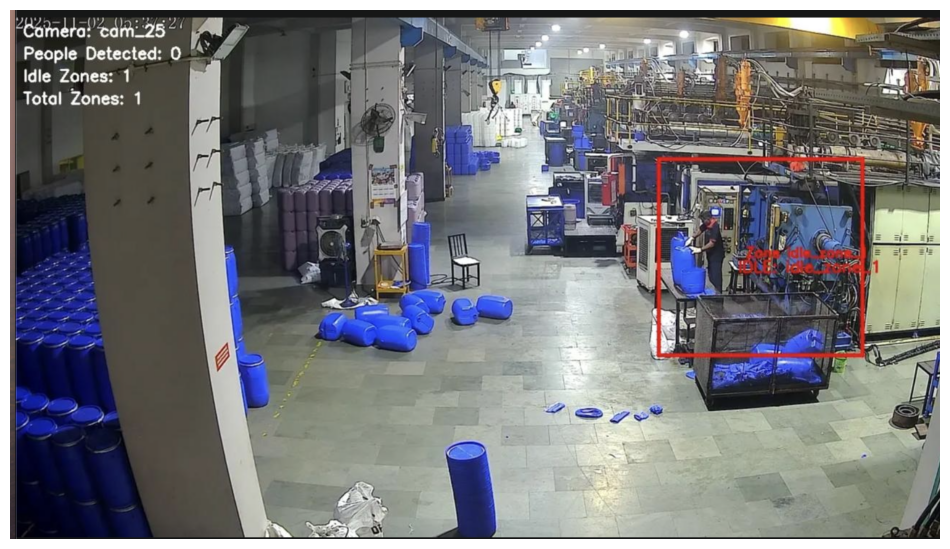

In [ ]:
# Colab cell — paste & run (replace paths as needed)
import os
import torch
import numpy as np
from PIL import Image
import supervision as sv
from rfdetr import RFDETRNano

# ---------------------------
# CONFIG (edit these)
# ---------------------------
checkpoint_path = "/content/drive/MyDrive/Guardex_Harshvardhan/RFDETR-DATA+TRAINING+INFERENCE/RFDETR-Finetuned-1280x720/checkpoint_best_ema.pth"
IMAGE_PATH = "/content/Screenshot 2025-11-04 at 2.07.04 PM.png"
THRESHOLD = 0.5
class_names = ["person"]   # list of class names in order (0-indexed)

# ---------------------------
# MODEL LOAD
# ---------------------------
model = RFDETRNano(pretrain_weights=checkpoint_path)
try:
    model.optimize_for_inference()
except Exception:
    pass

# ---------------------------
# helpers (from your previous code, slightly tightened)
# ---------------------------
def _to_float_if_scalar(x):
    if x is None:
        return None
    if isinstance(x, torch.Tensor):
        try:
            return float(x.detach().cpu().item())
        except Exception:
            return None
    if isinstance(x, (np.generic, np.ndarray)):
        try:
            arr = np.array(x)
            if arr.size == 1:
                return float(arr.reshape(-1)[0])
            return None
        except Exception:
            return None
    if isinstance(x, (float, int)):
        return float(x)
    try:
        return float(x)
    except Exception:
        return None

def _is_bbox_like(x):
    if x is None:
        return False
    if isinstance(x, torch.Tensor):
        try:
            arr = x.detach().cpu().numpy()
            return arr.size >= 4
        except Exception:
            return False
    try:
        arr = np.array(x, dtype=np.float32)
        return arr.size >= 4
    except Exception:
        return False

def _parse_detection(det):
    """
    Return (bbox_list_of_4_floats, confidence_float_or_0.0, class_id_int_or_None)
    or (None, None, None) if bbox can't be found.
    """
    bbox = None
    conf = None
    cls = None

    # tuple/list: scan elements
    if isinstance(det, (list, tuple)):
        for elem in det:
            if bbox is None and _is_bbox_like(elem):
                try:
                    if isinstance(elem, torch.Tensor):
                        arr = elem.detach().cpu().numpy().astype(np.float32).reshape(-1)
                    else:
                        arr = np.array(elem, dtype=np.float32).reshape(-1)
                    bbox = arr[:4].tolist()
                    continue
                except Exception:
                    pass
            if conf is None:
                val = _to_float_if_scalar(elem)
                if val is not None and 0.0 <= val <= 1.0:
                    conf = float(val)
                    continue
            if cls is None:
                val = _to_float_if_scalar(elem)
                if val is not None and abs(val - round(val)) < 1e-6:
                    cls = int(round(val))
                    continue
        if conf is None:
            for elem in det:
                val = _to_float_if_scalar(elem)
                if val is not None:
                    conf = float(val)
                    break

    # dict-like
    elif isinstance(det, dict):
        bbox_candidate = det.get('bbox') or det.get('box') or det.get('xyxy') or det.get('boxes') or det.get('bboxes')
        if _is_bbox_like(bbox_candidate):
            arr = np.array(bbox_candidate, dtype=np.float32).reshape(-1)[:4]
            bbox = arr.tolist()
        conf_candidate = det.get('score') or det.get('confidence') or det.get('scores')
        cval = _to_float_if_scalar(conf_candidate)
        if cval is not None:
            conf = float(cval)
        cls_candidate = det.get('class') or det.get('label') or det.get('class_id') or det.get('class_ids')
        kval = _to_float_if_scalar(cls_candidate)
        if kval is not None:
            cls = int(round(kval))

    # object-like
    else:
        for attr in ('bbox','xyxy','box','boxes','bboxes'):
            if hasattr(det, attr):
                val = getattr(det, attr)
                if _is_bbox_like(val):
                    arr = np.array(val, dtype=np.float32).reshape(-1)[:4]
                    bbox = arr.tolist()
                    break
        for attr in ('score','scores','confidence','conf'):
            if conf is None and hasattr(det, attr):
                val = _to_float_if_scalar(getattr(det, attr))
                if val is not None:
                    conf = float(val)
        for attr in ('label','class_id','class','class_ids'):
            if cls is None and hasattr(det, attr):
                val = _to_float_if_scalar(getattr(det, attr))
                if val is not None:
                    cls = int(round(val))

    if bbox is None:
        return None, None, None
    if conf is None:
        conf = 0.0
    # leave cls possibly None here
    return bbox, float(conf), (int(cls) if cls is not None else None)

# ---------------------------
# load & prepare image
# ---------------------------
def load_and_prepare(path):
    img = Image.open(path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

image = load_and_prepare(IMAGE_PATH)

# ---------------------------
# run inference & parse detections
# ---------------------------
detections = model.predict(image, threshold=THRESHOLD)
print("Raw detections count:", len(detections))

if len(detections) == 0:
    print("⚠️ No detections found.")
    annotated = image.copy()
else:
    print("RAW DETECTIONS SAMPLE (first 4):")
    for i, d in enumerate(detections[:4]):
        print(f"[{i}] type={type(d)} repr={repr(d)[:400]}")

    xyxy_list = []
    conf_list = []
    cid_list = []

    for det in detections:
        bbox, conf, cid = _parse_detection(det)
        if bbox is None:
            continue
        xyxy_list.append(bbox)
        conf_list.append(conf)
        cid_list.append(cid if cid is not None else -1)  # use -1 for unknown

    if len(xyxy_list) == 0:
        print("⚠️ After parsing, no valid detections remained.")
        annotated = image.copy()
    else:
        xyxy = np.array(xyxy_list, dtype=np.float32)
        confidences = np.array(conf_list, dtype=np.float32)
        class_ids = np.array(cid_list, dtype=np.int32)

        # Build supervisor detections
        detections_sv = sv.Detections(
            xyxy=xyxy,
            confidence=confidences,
            class_id=class_ids
        )

        # ---------------------------
        # Robust label creation (handles 1-based classes and out-of-range ids)
        # ---------------------------
        orig_ids = class_ids.tolist()
        confs = confidences.tolist()

        # Detect 1-based convention: all ids in 1..len(class_names)
        is_one_based = False
        if len(class_names) > 0:
            # consider only non-negative ids (we used -1 for unknown)
            numeric_ids = [i for i in orig_ids if i >= 0]
            if len(numeric_ids) > 0 and all(1 <= i <= len(class_names) for i in numeric_ids):
                is_one_based = True

        # convert if needed
        if is_one_based:
            mapped_ids = [(i - 1) if i >= 0 else i for i in orig_ids]
        else:
            mapped_ids = orig_ids

        labels = []
        for cid, conf in zip(mapped_ids, confs):
            if 0 <= cid < len(class_names):
                name = class_names[int(cid)]
            elif cid < 0:
                name = "unknown"
            else:
                name = f"class_{int(cid)}"
            try:
                conf_val = float(conf)
            except Exception:
                conf_val = 0.0
            labels.append(f"{name} {conf_val:.2f}")

        # debug prints (optional)
        print("DEBUG orig_ids:", orig_ids)
        print("DEBUG mapped_ids (0-based):", mapped_ids)
        print("DEBUG labels:", labels)

        # annotate
        box_annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()

        annotated = box_annotator.annotate(image.copy(), detections_sv)
        annotated = label_annotator.annotate(annotated, detections_sv, labels=labels)

# ---------------------------
# show result
# ---------------------------
sv.plot_image(annotated)